In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)

%matplotlib inline
cmap = plt.get_cmap('Set1')

In [3]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
bucket_path = join(eCON,'SCR_new/dataset/results_ShockUncensored/{subj}/{group}/splitted_regs/noProx/buttonPress/{subj}_bucket_REML_clean.1D')
yoked = pd.read_excel(join(eCON,'SCR_new/scripts/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

N = 57

effects = 'signNearest signNear signFar magNearest magNear magFar signXmagNearest signXmagNear signXmagFar v_motion block_onset block_offset'.split()

In [4]:
def combine_beta(beta,t):
    weights = (t/beta)**2
    combined_beta = np.sum(weights*beta,axis=0)/np.sum(weights,axis=0)
    return combined_beta

In [5]:
if exists('Individual_betas_from_SCR_analysis_S_buttonPress.csv'):
    shock_df = pd.read_csv('Individual_betas_from_SCR_analysis_S_buttonPress.csv')
else:
    shock_df = pd.DataFrame()
    for i,row in yoked.iterrows():
        for kind in ['control','uncontrol']:
            subj = row[kind]
            group = kind+'lable'
            nruns = np.sum(row.loc['run0':'run5'].astype(bool))
            data = np.loadtxt(bucket_path.format(subj=subj,group=group))

            shock_est = data[25:][:nruns*2]
            beta = shock_est[::2]
            t = shock_est[1::2]
            combined_beta = combine_beta(beta=beta,t=t)
            #print('-'*50)
            #print(subj)
            #print('betas: ',beta)
            #print('tstat: ',t)
            tmp_df = pd.DataFrame({'Pair':['P{:02}'.format(i)],'Subject':[subj],'Group':[kind],'shock':[combined_beta]})
            shock_df = pd.concat([shock_df,tmp_df],axis=0,ignore_index=True)

shock_df.to_csv('Individual_betas_from_SCR_analysis_S_buttonPress.csv',index=False)

In [8]:
effects_df = pd.DataFrame()

for i,row in yoked.iterrows():
    for kind in ['control','uncontrol']:
        subj = row[kind]
        group = kind+'lable'
        betas = np.loadtxt(bucket_path.format(subj=subj,group=group))
        tmp_pd = pd.DataFrame(betas[1::2][:12],index=effects).T
        tmp_pd['Subject'] = row[kind]
        tmp_pd['Group'] = kind
        tmp_pd['Pair'] = 'P{:02d}'.format(i)
        
        effects_df = pd.concat([effects_df,tmp_pd],axis=0,ignore_index=True)

In [9]:
df = pd.merge(shock_df,effects_df)
print(df.shape)
df.head()

(114, 16)


,Pair,Subject,Group,shock,signNearest,signNear,signFar,magNearest,magNear,magFar,signXmagNearest,signXmagNear,signXmagFar,v_motion,block_onset,block_offset
0,P00,CON001,control,3.863367,0.421400,-0.016414,0.008958,0.046983,0.030319,0.022981,0.191093,-0.024593,0.075500,-0.025930,0.464878,-0.005874
1,P00,CON031,uncontrol,1.134769,0.753854,-0.046420,0.033977,0.229416,0.010673,-0.024889,0.535462,-0.037987,0.053637,-0.001545,0.089154,0.000000
2,P01,CON002,control,-0.029041,0.737437,0.026661,0.026073,0.396078,0.036337,0.009080,0.452969,0.045185,0.102221,-0.007340,0.615194,-0.211130
3,P01,CON021,uncontrol,1.712403,0.742622,-0.083802,0.046214,0.245902,0.003968,0.008121,0.528427,-0.062364,0.064304,0.004910,-0.045979,0.000000
4,P02,CON003,control,2.271669,0.649230,-0.080691,0.052268,0.176853,0.013468,0.002858,0.464608,-0.067258,0.056004,-0.003538,0.296575,0.118150


In [10]:
paired_df = df[df['Group']=='uncontrol'].set_index(['Pair']).drop(['Subject','Group'],axis=1) - df[df['Group']=='control'].set_index(['Pair']).drop(['Subject','Group'],axis=1)
paired_df.head()

,shock,signNearest,signNear,signFar,magNearest,magNear,magFar,signXmagNearest,signXmagNear,signXmagFar,v_motion,block_onset,block_offset
Pair,,,,,,,,,,,,,
P00,-2.728599,0.332454,-0.030006,0.025019,0.182433,-0.019646,-0.047870,0.344369,-0.013394,-0.021863,0.024385,-0.375724,0.005874
P01,1.741444,0.005185,-0.110462,0.020141,-0.150176,-0.032369,-0.000960,0.075458,-0.107549,-0.037917,0.012250,-0.661173,0.211130
P02,1.019240,-0.975134,0.134884,-0.070751,-0.072512,-0.018990,0.027447,-0.682575,0.119236,-0.074548,0.058823,0.536188,-0.118150
P03,1.826244,-0.565278,0.067748,-0.069259,-0.466386,-0.025679,-0.014002,-0.284479,0.054142,0.012347,-0.010160,-0.727510,0.040672
P04,-0.052512,-0.055575,0.019098,-0.023681,0.012879,-0.040897,0.026550,-0.048397,0.003403,0.037387,0.011232,-0.541654,-0.181490


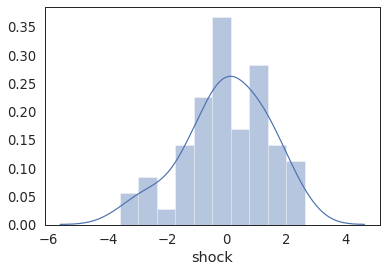

In [11]:
sns.distplot(paired_df['shock'],bins=10)

In [12]:
from scipy.stats import ttest_rel, ttest_ind, ttest_1samp
ttest_1samp(paired_df['shock'],0)

Ttest_1sampResult(statistic=-0.059497828734476586, pvalue=0.952767413791141)

In [13]:
results_df = pd.DataFrame(columns=['effect','uncontrol vs. control\n(tstat, p-value)','uncontrol\n(tstat, p-value)','control\n(tstat, p-value)'])
for effect in effects + ['shock']:
    if effect not in ['v_motion','block_onset','block_offset']:
        uncon = tuple(np.round(a,decimals=3) for a in ttest_1samp(df[df['Group']=='uncontrol'][effect],0))
        con = tuple(np.round(a,decimals=3) for a in ttest_1samp(df[df['Group']=='control'][effect],0))
        uncon_v_con = tuple(np.round(a,decimals=3) for a in ttest_rel(df[df['Group']=='uncontrol'][effect],df[df['Group']=='control'][effect]))

        tmp_df= pd.DataFrame([effect,uncon_v_con,uncon,con],index=['effect','uncontrol vs. control\n(tstat, p-value)','uncontrol\n(tstat, p-value)','control\n(tstat, p-value)']).T
        results_df = pd.concat([results_df,tmp_df],axis=0)

In [14]:
results_df['effect'] = results_df['effect'].apply(lambda string: string.replace('sign','Direction'))
results_df['effect'] = results_df['effect'].apply(lambda string: string.replace('mag','Speed'))

In [15]:
results_df

,effect,"uncontrol vs. control (tstat, p-value)","uncontrol (tstat, p-value)","control (tstat, p-value)"
0,DirectionNearest,"(0.057, 0.955)","(6.561, 0.0)","(6.275, 0.0)"
0,DirectionNear,"(-0.798, 0.428)","(-1.717, 0.091)","(-0.733, 0.467)"
0,DirectionFar,"(0.602, 0.55)","(-0.992, 0.325)","(-1.778, 0.081)"
0,SpeedNearest,"(-0.75, 0.456)","(1.715, 0.092)","(2.978, 0.004)"
0,SpeedNear,"(-2.692, 0.009)","(1.722, 0.091)","(5.651, 0.0)"
0,SpeedFar,"(-0.078, 0.938)","(3.163, 0.003)","(3.858, 0.0)"
0,DirectionXSpeedNearest,"(0.064, 0.949)","(6.277, 0.0)","(6.948, 0.0)"
0,DirectionXSpeedNear,"(-0.244, 0.808)","(-0.074, 0.941)","(0.258, 0.797)"
0,DirectionXSpeedFar,"(-0.48, 0.633)","(10.75, 0.0)","(10.827, 0.0)"
0,shock,"(-0.059, 0.953)","(15.103, 0.0)","(16.048, 0.0)"


# **Shock**
## **SCR response distributions of the two groups**
- Compare the distributions
    - Two (Independent) Sample Test
    - Related Sample Test

### **Two (Independent) Sample Test**

$$H_{0}:\mu_{SCR_{uncontrol}} \neq \mu_{SCR_{control}}$$

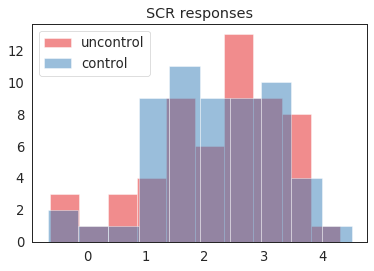

In [17]:
uncon_scr = shock_df[shock_df['Group']=='uncontrol']['shock'].values
con_scr = shock_df[shock_df['Group']=='control']['shock'].values

_=plt.hist(uncon_scr,alpha=0.5,color=cmap.colors[0],label='uncontrol')
_=plt.hist(con_scr,alpha=0.5,color=cmap.colors[1],label='control')
_=plt.title('SCR responses')
_=plt.legend()

In [18]:
def ind_samp_perm_test(treatment, control, n_perms):
    n, k, samp_dist = len(treatment), 0, []
    real_obs = np.abs(np.mean(treatment) - np.mean(control))
    zs = np.concatenate([treatment, control])
    for j in range(n_perms):
        np.random.shuffle(zs)
        obs = np.mean(zs[:n]) - np.mean(zs[n:])
        samp_dist.append(obs)
        k += real_obs < abs(obs)
    return (samp_dist,(k+1)/(n_perms+1))

In [20]:
print('Independent samples ttest p-value: %.3f' %(ttest_ind(uncon_scr,con_scr)[1]))
samp_dist, p_val = ind_samp_perm_test(uncon_scr,con_scr,50000)
print('Independent sample permutation test p-value: %.3f' %(p_val))

Independent samples ttest p-value: 0.955
Independent sample permutation test p-value: 0.954


Text(0.5, 1.0, 'Two sample permutation test p-value: 0.954')

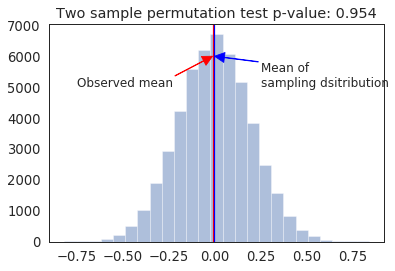

In [21]:
_=plt.hist(samp_dist,bins=25,alpha=0.45)
plt.axvline(x=np.mean(uncon_scr) - np.mean(con_scr),c='red',label='Observed mean')
plt.axvline(x=np.mean(samp_dist),c='blue',label='Mean of \nsampling dsitribution')
plt.annotate('Observed mean',
             xy=(np.mean(uncon_scr) - np.mean(con_scr),6000),
             xytext=(-0.75,5000), arrowprops={'color':'red','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
plt.annotate('Mean of \nsampling dsitribution',
             xy=(np.mean(samp_dist),6000),
             xytext=(0.25,5000), arrowprops={'color':'blue','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
plt.title('Two sample permutation test p-value: %.3f' %(p_val))

### **Paired Sample Test**
$$H_{0}: \mu_{SCR_{uncontol-control}} = 0$$

In [22]:
def rel_samp_perm_test(treatment,control,n_perms):
    n, k, samp_dist = len(treatment), 0, []
    alt_obs = abs(np.mean(np.subtract(treatment,control)))
    scr = np.stack([treatment,control],axis=0) # making a 2 X num_samples array
    for j in range(n_perms):
        null_obs = np.mean(np.array([np.random.choice([-1,1]) for i in range(n)])*(scr[0,:]-scr[1,:]))
        samp_dist.append(null_obs)
        k += abs(null_obs) > alt_obs
        
    return(samp_dist,(k+1)/(n_perms+1))

In [23]:
print('Related Samples T-test p-value: %.3f' %(ttest_rel(uncon_scr,con_scr)[1]))
samp_dist, p_val = rel_samp_perm_test(uncon_scr,con_scr,50000)
print('Related Samples permutation test p-value: %.3f' %(p_val))

Related Samples T-test p-value: 0.953
Related Samples permutation test p-value: 0.953


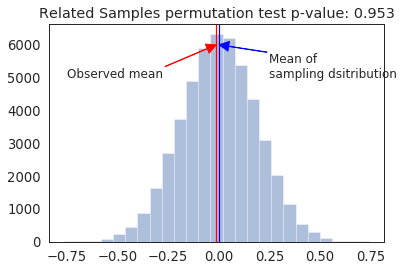

In [24]:
_=plt.hist(samp_dist,bins=25,alpha=0.45)
plt.axvline(x=np.mean(uncon_scr-con_scr),c='red',label='Observed mean')
plt.axvline(x=np.mean(samp_dist),c='blue',label='Mean of \nsampling dsitribution')
plt.annotate('Observed mean',
             xy=(np.mean(uncon_scr-con_scr),6000),
             xytext=(-0.75,5000), arrowprops={'color':'red','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
_=plt.annotate('Mean of \nsampling dsitribution',
             xy=(np.mean(samp_dist),6000),
             xytext=(0.25,5000), arrowprops={'color':'blue','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
_=plt.title('Related Samples permutation test p-value: %.3f' %(p_val))

# **SCR vs. Right BST Response**

In [41]:
# Load ROI analysis betas
roi_df = pd.read_csv('Individual_betas_from_ROI_analysis_S_buttonPress.csv')
roi_df = roi_df[roi_df['ROI']=='rBNST']
roi_df.drop('ROI',axis=1,inplace=True)
roi_df.rename(columns={'beta':'rBNST'},inplace=True)
print('roi_df size: ',roi_df.shape)
roi_df.head()

roi_df size:  (122, 4)


,Pair,Subject,Group,rBNST
0,P00,CON001,control,0.640981
1,P00,CON031,uncontrol,1.259554
2,P01,CON002,control,0.757035
3,P01,CON021,uncontrol,0.063796
4,P02,CON003,control,0.583921


In [42]:
shock_df.head()

,Pair,Subject,Group,shock
0,P00,CON001,control,3.863367
1,P00,CON031,uncontrol,1.134769
2,P01,CON002,control,-0.029041
3,P01,CON021,uncontrol,1.712403
4,P02,CON003,control,2.271669


In [45]:
df = pd.merge(shock_df,roi_df)

Text(0, 0.5, 'Right BST response')

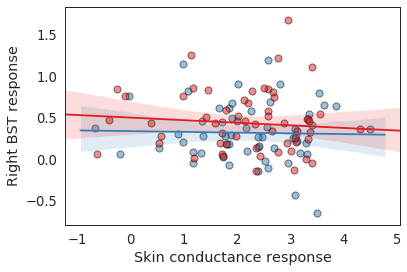

In [52]:
sns.regplot(x='shock',y='rBNST', data = df[df['Group']=='control'],color=cmap.colors[1],
                scatter_kws= {'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[1]},label='control',robust=True)

sns.regplot(x='shock',y='rBNST', data = df[df['Group']=='uncontrol'],color=cmap.colors[0],
                scatter_kws= {'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[0]},label='control',robust=True)
plt.xlabel('Skin conductance response')
plt.ylabel('Right BST response')